In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:

# مسیر اصلی دایرکتوری رو تعریف می‌کنیم
dataset_path = r"E:\Datasets\People Clothing Segmentation"

# مسیر هر پوشه رو مشخص می‌کنیم
jpeg_images_path = os.path.join(dataset_path, "jpeg_images")
jpeg_masks_path = os.path.join(dataset_path, "jpeg_masks")
png_images_path = os.path.join(dataset_path, "png_images")
png_masks_path = os.path.join(dataset_path, "png_masks")

# تعداد فایل‌ها رو تو هر پوشه می‌شماریم
jpeg_images_count = len(os.listdir(jpeg_images_path))
jpeg_masks_count = len(os.listdir(jpeg_masks_path))
png_images_count = len(os.listdir(png_images_path))
png_masks_count = len(os.listdir(png_masks_path))

# نتایج رو چاپ می‌کنیم
print(f"تعداد تصاویر JPEG: {jpeg_images_count}")
print(f"تعداد ماسک‌های JPEG: {jpeg_masks_count}")
print(f"تعداد تصاویر PNG: {png_images_count}")
print(f"تعداد ماسک‌های PNG: {png_masks_count}")

تعداد تصاویر JPEG: 1000
تعداد ماسک‌های JPEG: 1000
تعداد تصاویر PNG: 1000
تعداد ماسک‌های PNG: 1000


In [3]:
image_files = sorted(os.listdir(png_images_path))
mask_files = sorted(os.listdir(png_masks_path))

In [4]:
def load_data(image_path, mask_path):
    # تصویر رو با PIL می‌خونیم و به آرایه numpy تبدیل می‌کنیم
    image = Image.open(os.path.join(image_path, image_files[3])).convert("RGB")
    image = np.array(image)
    
    # ماسک رو می‌خونیم و به آرایه تبدیل می‌کنیم (به grayscale)
    mask = Image.open(os.path.join(mask_path, mask_files[3])).convert("L")
    mask = np.array(mask)
    
    return image, mask

In [5]:
image, mask = load_data(png_images_path,png_masks_path)

In [6]:
print(f"شکل تصویر: {image.shape}")
print(f"شکل ماسک: {mask.shape}")

شکل تصویر: (825, 550, 3)
شکل ماسک: (825, 550)


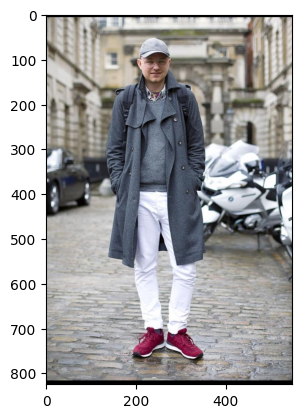

In [7]:
plt.imshow(image)

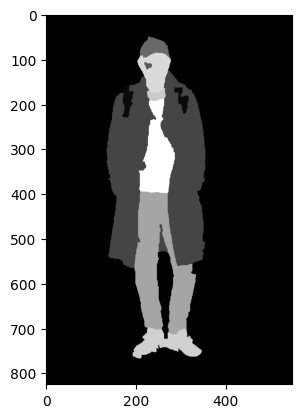

In [8]:
plt.imshow(mask,cmap='gray')

In [9]:
type(mask)

numpy.ndarray

In [10]:
np.unique(mask)

array([ 0,  2, 13, 17, 20, 31, 38, 39, 41, 48], dtype=uint8)

In [11]:
def preprocess_data(image_path, mask_path, target_size=(256, 256)):
    images = []
    masks = []
    
    
    for img_file, mask_file in zip(image_files, mask_files):
       
        image = Image.open(os.path.join(image_path, img_file)).convert("RGB")
        image = image.resize(target_size, Image.Resampling.LANCZOS)
        image = np.array(image)
        image = image / 255.0
        
        
        mask = Image.open(os.path.join(mask_path, mask_file)).convert("L")
        mask = mask.resize(target_size, Image.Resampling.NEAREST)
        mask = np.array(mask)
        
        
        images.append(image)
        masks.append(mask)
    
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks



In [12]:
images, masks = preprocess_data(png_images_path, png_masks_path)

print(f"شکل دیتاست تصاویر: {images.shape}")
print(f"شکل دیتاست ماسک‌ها: {masks.shape}")
print(f"محدوده مقادیر تصویر: {images.min()} تا {images.max()}")
print(f"محدوده مقادیر ماسک: {masks.min()} تا {masks.max()}")

شکل دیتاست تصاویر: (1000, 256, 256, 3)
شکل دیتاست ماسک‌ها: (1000, 256, 256)
محدوده مقادیر تصویر: 0.0 تا 1.0
محدوده مقادیر ماسک: 0 تا 58


In [102]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=59):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=0.2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        # Middle
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        # Decoder (Upsampling)
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # خروجی
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        c1 = self.dropout(F.relu(self.conv2(F.relu(self.conv1(x)))))
        p1 = self.pool(c1)
        c2 = self.dropout(F.relu(self.conv4(F.relu(self.conv3(p1)))))
        p2 = self.pool(c2)
        c3 = self.dropout(F.relu(self.conv6(F.relu(self.conv5(p2)))))
        up1 = self.upconv1(c3)
        concat1 = torch.cat([c2, up1], dim=1)
        c4 = self.dropout(F.relu(self.conv8(F.relu(self.conv7(concat1)))))
        up2 = self.upconv2(c4)
        concat2 = torch.cat([c1, up2], dim=1)
        c5 = self.dropout(F.relu(self.conv10(F.relu(self.conv9(concat2)))))
        out = self.conv11(c5)
        return out



In [103]:
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms

In [104]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # تغییر اندازه
    transforms.RandomHorizontalFlip(p=0.5),  # چرخش افقی تصادفی
    transforms.RandomRotation(degrees=15),  # چرخش تصادفی تا 15 درجه
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # تغییر روشنایی، کنتراست و saturation
    transforms.ToTensor(),  # تبدیل به تنسور (و نرمال‌سازی به 0-1)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # فقط تغییر اندازه
    transforms.ToTensor(),  # تبدیل به تنسور
])

In [105]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])
    

In [106]:
class ClothingSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir , transform = None ):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir,self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((256,256))(mask)
            mask = transforms.ToTensor()(mask)
            mask = (mask * 255).long()
            mask = mask.squeeze()

        return image,mask
        

In [107]:
total_size = len(full_dataset)
print(f"تعداد کل تصاویر: {total_size}")
train_size = int(0.7 * total_size)  # 700
val_size = int(0.2 * total_size)   # 200
test_size = total_size - train_size - val_size  # 100
print(f"تعداد train: {train_size}, validation: {val_size}, test: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# اعمال ترانسفورم‌ها بعد از تقسیم‌بندی
train_dataset.dataset = ClothingSegmentationDataset(
    image_dir=r"E:\Datasets\People Clothing Segmentation\png_images",
    mask_dir=r"E:\Datasets\People Clothing Segmentation\png_masks",
    transform=train_transform
)
val_dataset.dataset = ClothingSegmentationDataset(
    image_dir=r"E:\Datasets\People Clothing Segmentation\png_images",
    mask_dir=r"E:\Datasets\People Clothing Segmentation\png_masks",
    transform=val_transform
)
test_dataset.dataset = ClothingSegmentationDataset(
    image_dir=r"E:\Datasets\People Clothing Segmentation\png_images",
    mask_dir=r"E:\Datasets\People Clothing Segmentation\png_masks",
    transform=val_transform
)



تعداد کل تصاویر: 1000
تعداد train: 700, validation: 200, test: 100


In [108]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=True)  # 200 تصویر برای اعتبارسنجی
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=True)  # 100 تصویر برای تست



In [109]:
print(f"تعداد تصاویر تو train_loader.dataset: {len(train_loader.dataset)}")
print(f"تعداد تصاویر تو val_loader.dataset: {len(val_loader.dataset)}")  # باید 200 باشه
print(f"تعداد تصاویر تو test_loader.dataset: {len(test_loader.dataset)}")  # باید 100 باشه

تعداد تصاویر تو train_loader.dataset: 700
تعداد تصاویر تو val_loader.dataset: 200
تعداد تصاویر تو test_loader.dataset: 100


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [111]:
model = UNet(in_channels=3,out_channels=59).to(device)

In [112]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [113]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs,save_path="unet_model.pth"):
    best_test_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images,masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs,masks)
                test_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f} - test Loss: {avg_test_loss:.4f}")
        
        # ذخیره بهترین مدل
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), save_path)
            print(f"بهترین مدل ذخیره شد با test Loss: {best_test_loss:.4f}")

In [114]:
train_model(model, train_loader, test_loader, criterion, optimizer, 40)

Epoch [1/40] - Loss: 1.6216 - test Loss: 2.6157
بهترین مدل ذخیره شد با test Loss: 2.6157
Epoch [2/40] - Loss: 1.3662 - test Loss: 2.4790
بهترین مدل ذخیره شد با test Loss: 2.4790
Epoch [3/40] - Loss: 1.3041 - test Loss: 2.4024
بهترین مدل ذخیره شد با test Loss: 2.4024
Epoch [4/40] - Loss: 1.2746 - test Loss: 2.3888
بهترین مدل ذخیره شد با test Loss: 2.3888
Epoch [5/40] - Loss: 1.2529 - test Loss: 2.4356
Epoch [6/40] - Loss: 1.2443 - test Loss: 2.3444
بهترین مدل ذخیره شد با test Loss: 2.3444
Epoch [7/40] - Loss: 1.2236 - test Loss: 2.3282
بهترین مدل ذخیره شد با test Loss: 2.3282
Epoch [8/40] - Loss: 1.2180 - test Loss: 2.3187
بهترین مدل ذخیره شد با test Loss: 2.3187
Epoch [9/40] - Loss: 1.2266 - test Loss: 2.4759
Epoch [10/40] - Loss: 1.2175 - test Loss: 2.3171
بهترین مدل ذخیره شد با test Loss: 2.3171
Epoch [11/40] - Loss: 1.2042 - test Loss: 2.2864
بهترین مدل ذخیره شد با test Loss: 2.2864
Epoch [12/40] - Loss: 1.2004 - test Loss: 2.2607
بهترین مدل ذخیره شد با test Loss: 2.2607
Epoch [13/4

In [96]:
def test_model(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    return pred

In [97]:
def visualize_prediction(image_path, pred):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((256, 256))
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("تصویر اصلی")
    plt.imshow(image)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("ماسک پیش‌بینی‌شده")
    plt.imshow(pred, cmap="jet")
    plt.axis("off")
    
    plt.show()

In [98]:
model.load_state_dict(torch.load("unet_model.pth"))
model = model.to(device)

C:\Users\Saeed\AppData\Local\Temp\ipykernel_11220\2739917675.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_model.pth"))


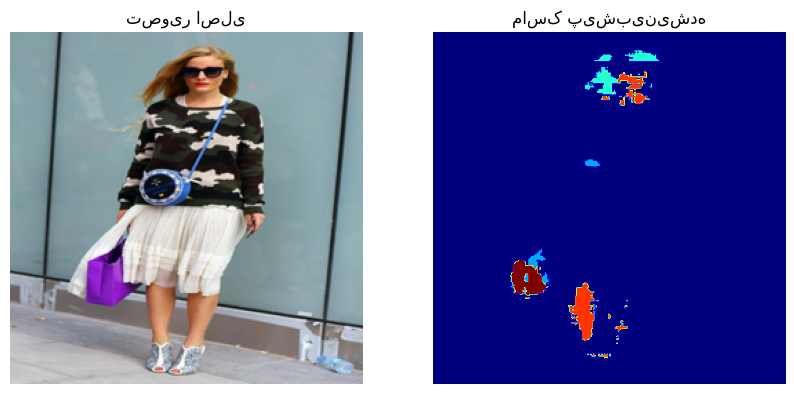

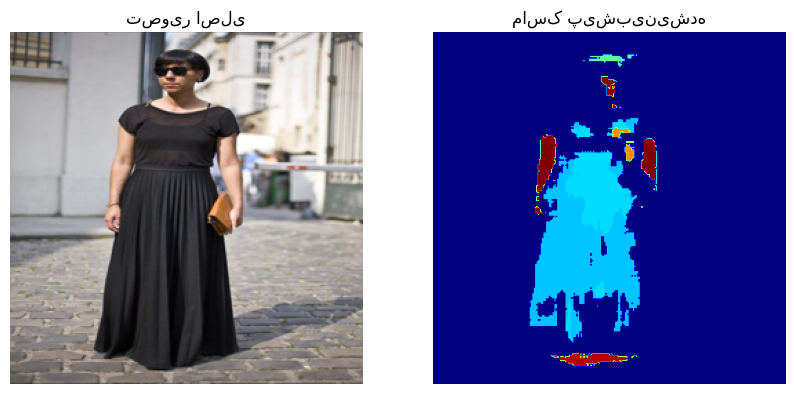

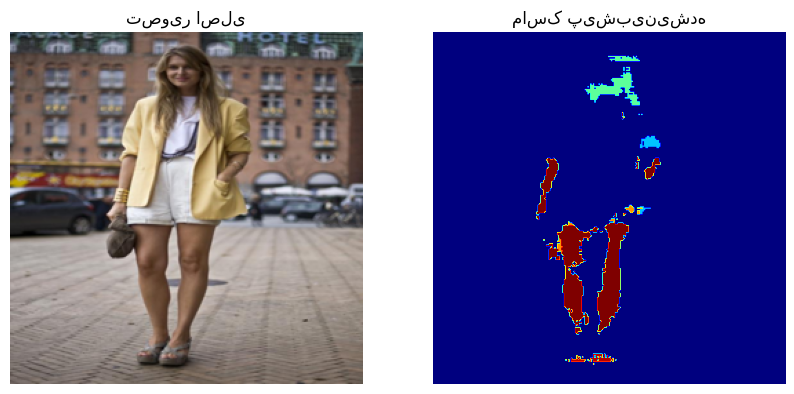

In [99]:
num_samples_to_show = min(3, len(test_loader.dataset))  # حداکثر 3 نمونه
for i in range(num_samples_to_show):
        image, mask = test_loader.dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        
        # اندیس تصویر تو دیتاست اصلی
        subset_idx = test_loader.dataset.indices[i]
        original_image_path = os.path.join(r"E:\Datasets\People Clothing Segmentation\png_images", 
                                         test_loader.dataset.dataset.images[subset_idx])
        visualize_prediction(original_image_path, pred)    

In [100]:
from sklearn.metrics import jaccard_score
def evaluate_test_model(model, test_loader, device):
    model.eval()
    total_iou = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # پیش‌بینی کلاس‌ها
            
            # تبدیل به آرایه numpy برای محاسبه IoU
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()
            
            # محاسبه IoU برای هر تصویر تو batch
            for pred, mask in zip(preds, masks):
                iou = jaccard_score(mask.flatten(), pred.flatten(), average='weighted', zero_division=0)
                total_iou += iou
                num_samples += 1
    
    avg_iou = total_iou / num_samples
    print(f"میانگین IoU روی دیتاست تست: {avg_iou:.4f}")

In [101]:
evaluate_test_model(model, val_loader, device)

میانگین IoU روی دیتاست تست: 0.6378
